In [1]:
from ML_utils import ML_utils
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

In [2]:
dir_path = r'D:\Backup\ml_data\GitHub\ML_Sentiment_analysis\Dataset'
x = np.load(os.path.join(dir_path,'vec_x_neg1000_pos1000.npy'))
y = np.load(os.path.join(dir_path,'vec_y_neg1000_pos1000.npy'))

In [3]:
x_train = np.concatenate((x[:500],x[1000:1500]))
y_train = np.concatenate((y[:500],y[1000:1500]))
x_test = np.concatenate((x[500:1000],x[1500:2000]))
y_test = np.concatenate((y[500:1000],y[1500:2000]))
del x,y

In [4]:
class Dataset(data.Dataset):
    def __init__(self,x,y,transform=None,target_transform=None):
#         self.transform = transform
#         self.target_transform = target_transform
        self.data_X = x
        self.data_Y = y
        
    def __getitem__(self, index):
        X = self.data_X[index]
        Y = self.data_Y[index]
#         if self.transform != None:
#             X = self.transform(X)
#         if self.target_transform != None:
#             Y = self.transform(Y)
        return X, Y
                
    def __len__(self):
        return len(self.data_X)

In [5]:
batch_size = 250
train_data = Dataset(x_train,y_train)
trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,shuffle=True, num_workers=0)
test_data = Dataset(x_train,y_train)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size ,shuffle=True, num_workers=0)
del train_data,test_data

In [6]:
seq_len = 60
input_size = 300
rnn_hidden_size = 100
rnn_num_layers = 2
output_size = 2
hidden_size = seq_len*rnn_hidden_size

class LSTM_model(nn.Module):
    def __init__(self, ):
        super(LSTM_model, self).__init__()
        self.lstm0 = nn.LSTM(
            input_size=input_size,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_num_layers,
            batch_first=True)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size, output_size)
        for name,p in self.named_parameters():
            if (name.find('rnn') == 0):
                nn.init.normal_(p, mean=0.0, std=0.001)
            elif (name.find('linear') == 0) and (name.find('weight') == 0):        
                nn.init.xavier_normal_(p)
    def forward(self, x, h0,c0):
        # [b, seq, h]
        out, (h0_,c0_) = self.lstm0(x, (h0,c0))
        out = out.reshape(-1,hidden_size)
        out = self.linear(out)
        out = self.linear1(out)
        return out, (h0_,c0_)

In [7]:
#[rnn_layer,b,hidden_size]
h0 = torch.zeros(rnn_num_layers, batch_size, rnn_hidden_size,device='cuda:0')
c0 =  torch.zeros(rnn_num_layers, batch_size, rnn_hidden_size,device='cuda:0')
model = LSTM_model()
model.cuda('cuda:0')

LSTM_model(
  (lstm0): LSTM(300, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=6000, out_features=6000, bias=True)
  (linear1): Linear(in_features=6000, out_features=2, bias=True)
)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [9]:
model.train()
lr = 0.00001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

Iteration: 10 Train.loss 0.1862734854221344
Iteration: 10 Test.loss 0.18828445672988892
Iteration: 20 Train.loss 0.12389868497848511
Iteration: 20 Test.loss 0.1256086826324463
Iteration: 30 Train.loss 0.08948933333158493
Iteration: 30 Test.loss 0.09512700140476227
Iteration: 40 Train.loss 0.06620549410581589
Iteration: 40 Test.loss 0.07293809205293655
Iteration: 50 Train.loss 0.05290196090936661
Iteration: 50 Test.loss 0.053301695734262466
Iteration: 60 Train.loss 0.038236409425735474
Iteration: 60 Test.loss 0.04022112116217613
Iteration: 70 Train.loss 0.037385061383247375
Iteration: 70 Test.loss 0.033029381185770035
Iteration: 80 Train.loss 0.024858104065060616
Iteration: 80 Test.loss 0.022365206852555275
Iteration: 90 Train.loss 0.017336208373308182
Iteration: 90 Test.loss 0.017788145691156387
Iteration: 100 Train.loss 0.016499236226081848
Iteration: 100 Test.loss 0.012947533279657364


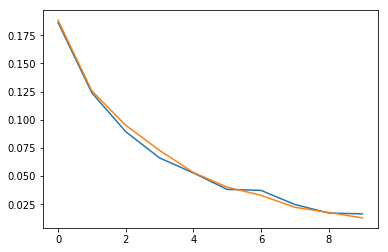

In [10]:
trainloss_list = []
testloss_list = []
for epoch in range(100):
    data_iter = iter(trainloader)
    for batch in data_iter:
        x = batch[0].to(device=device,dtype=dtype)
        y = batch[1].to(device=device,dtype=dtype)
        output,(h0_,c0_) = model(x, h0, c0)
        h0 = h0_.detach()
        c0 = c0_.detach()
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
#         for p in model.parameters():
#             torch.nn.utils.clip_grad_norm_(p, 10)
        optimizer.step()
#     print("Iteration: {} loss {}".format(epoch+1, loss.item()))
#     loss_list.append(loss.item())
    if (epoch+1) % 10 == 0:
        print("Iteration: {} Train.loss {}".format(epoch+1, loss.item()))
        trainloss_list.append(loss.item())
    data_iter = iter(testloader)
    for batch in data_iter:
        x = batch[0].to(device=device,dtype=dtype)
        y = batch[1].to(device=device,dtype=dtype)
        output,(h0_,c0_) = model(x, h0, c0)
        h0 = h0_.detach()
        c0 = c0_.detach()
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
#         for p in model.parameters():
#             torch.nn.utils.clip_grad_norm_(p, 10)
        optimizer.step()
#     print("Iteration: {} loss {}".format(epoch+1, loss.item()))
#     loss_list.append(loss.item())
    if (epoch+1) % 10 == 0:
        print("Iteration: {} Test.loss {}".format(epoch+1, loss.item()))
        testloss_list.append(loss.item())
plt.plot(trainloss_list)
plt.plot(testloss_list)
plt.show()

In [14]:
import re
import logging
class predict():
    def __init__(self,h0,c0,word_vec_model):
        self.pre_h0 = h0.clone().detach()
        self.pre_c0 = c0.clone().detach()
        self.word_vec_model = word_vec_model

    def jieba_string(self,chat):
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
        logging.disable(50)
        output = []
        # jieba custom setting.
        jieba.set_dictionary('jieba_dict/dict.txt.big')
        # load stopwords set
        #將停用詞每row分別加進集合
        stopword_set = set()
        #設置停用詞讀取路徑
        with open('jieba_dict/robot_stop_1.txt','r', encoding='utf-8') as stopwords:
            for stopword in stopwords:
                stopword_set.add(stopword.strip('\n'))   #移除頭尾換行 strip('\n')
        chat = chat.strip('\n')
        words = jieba.cut(chat, cut_all=False,HMM=True)    #進行斷詞
        for word in words:
            #依每個詞判斷是否為停用詞(不是就寫入)
            if word not in stopword_set:
                output.append(word)
        return output

    def chat(self,chat):
        jieba_list = self.jieba_string(chat)
        if len(jieba_list) > seq_len:
            jieba_list = jieba_list[:seq_len]
        if len(jieba_list) < seq_len:
            for num in range(seq_len-len(jieba_list)):
                jieba_list.append(0)
        padding = np.zeros((1,300),dtype=np.float32)
        vec_array = np.zeros((1,300),dtype=np.float32)
        for word in jieba_list:
            if word == 0:
                vec = padding
                vec_array = np.concatenate((vec_array,vec),axis=0)
            else:
                try:
                    vec = np.array(self.word_vec_model.wv.get_vector(word),np.float32).reshape(1,300)
                    vec_array = np.concatenate((vec_array,vec),axis=0)
                except KeyError:
                    vec = padding
                    vec_array = np.concatenate((vec_array,vec),axis=0)
        X = vec_array[1:].reshape(1,-1,300)
        X = torch.tensor(X)
        return X

    def input_to_robot(self,chat_input):
        x = self.chat(chat_input)
        x = x.to(device=device,dtype=dtype)
        output,(h0_,c0_)= model(x, self.pre_h0[:,:len(x),:].clone(), self.pre_c0[:,:len(x),:].clone())
        self.pre_h0 = h0_.detach()
        self.pre_c0 = c0_.detach()
        return output

In [ ]:
from gensim.models import word2vec
import logging
word_vec_path = r'D:\Backup\ml_data\GitHub\ML_Sentiment_analysis\word2vec_model\word2vec_model'
word_vec_model = word2vec.Word2Vec.load(word_vec_path)
pred = predict(h0,c0,word_vec_model)

In [1]:
pred.input_to_robot('好棒')

NameError: name 'pred' is not defined